This notebook is based on the following blog:
https://medium.com/@babatundeoreoluwa35/image-classification-using-transfer-learning-crop-disease-classification-dc4dedab17cb

### Import dependencies

In [19]:
#!pip3 install tensorflow

In [20]:
#!pip3 install keras

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers

import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

from PIL import Image
import os
import matplotlib.pyplot as plt

### Extract / Transform / Load the data

In [23]:
Train_df=pd.read_csv('/content/drive/MyDrive/crop-disease/Train.csv')
Test_df=pd.read_csv('/content/drive/MyDrive/crop-disease/Test.csv')

Let’s check what the data looks like

In [24]:
Train_df.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [25]:
Test_df.head()

,Image_id
0,id_00exusbkgzw1b.jpg
1,id_03dqinf6w0znv.jpg
2,id_046yl0cxn3ybz.jpg
3,id_04athdtx2abyg.jpg
4,id_062aauf9e9jk0.jpg


In [26]:
images_path='/content/drive/MyDrive/crop-disease/images/'

Merge Train_data column 'Image_id' with the image path

Then do same for the Test_data

In [27]:
''' ATTENTION
AFTER FIRST RUN OF THE BELOW CODE,
DO NOT RE-RUN THIS CELL UNLESS YOU RUN THE "pd.read_csv" FIRST
(otherwise the 'for loop' will create an incorrect 'Image_id')
'''
Train_df['Image_id']= [images_path+i for i in Train_df.Image_id]
Train_df['Label']= Train_df['Label'].astype(str)
Train_df

,Image_id,Label
0,/content/drive/MyDrive/crop-disease/images/id_...,1
1,/content/drive/MyDrive/crop-disease/images/id_...,0
2,/content/drive/MyDrive/crop-disease/images/id_...,0
3,/content/drive/MyDrive/crop-disease/images/id_...,1
4,/content/drive/MyDrive/crop-disease/images/id_...,1
...,...,...
1614,/content/drive/MyDrive/crop-disease/images/id_...,0
1615,/content/drive/MyDrive/crop-disease/images/id_...,1
1616,/content/drive/MyDrive/crop-disease/images/id_...,0
1617,/content/drive/MyDrive/crop-disease/images/id_...,0


In [28]:
type(Train_df['Image_id'][0])
Train_df['Image_id'][0]

'/content/drive/MyDrive/crop-disease/images/id_02amazy34fgh2.jpg'

In [29]:
type(Train_df['Label'][10])

str

In [30]:
''' ATTENTION
AFTER FIRST RUN OF THE BELOW CODE,
DO NOT RE-RUN THIS CELL UNLESS YOU RUN THE "pd.read_csv" FIRST
(otherwise the 'for loop' will create an incorrect 'Image_id')
'''
Test_df['Image_id']= [images_path+i for i in Test_df.Image_id]
Test_df

,Image_id
0,/content/drive/MyDrive/crop-disease/images/id_...
1,/content/drive/MyDrive/crop-disease/images/id_...
2,/content/drive/MyDrive/crop-disease/images/id_...
3,/content/drive/MyDrive/crop-disease/images/id_...
4,/content/drive/MyDrive/crop-disease/images/id_...
...,...
1075,/content/drive/MyDrive/crop-disease/images/id_...
1076,/content/drive/MyDrive/crop-disease/images/id_...
1077,/content/drive/MyDrive/crop-disease/images/id_...
1078,/content/drive/MyDrive/crop-disease/images/id_...


### Preprocess the data for modelling

For this project, we would be using the **ImageDataGenerator** to augment the images and **.flow_from_dataframe** to load the data. After rescaling all the images to a particular size we then augment the images.

**flow_from_dataframe** will be very useful to us. It checks the path available on the dataframe and then automatically search for the image in train directory. Then it make the desired preprocessing steps available in ImageDataGenerator (mitigates memory usage)

Note: It is not compulsory to augment image data, we only augment image data to improve the performance and the outcome of the model by forming new and different examples to the train and validation datasets

When you use the **.flow from_dataframe data loader**, pass in the csv file, the image_id as the x column ,the target as the y column, the target_size of the images the class_mode, subset,seed and batch _size. There are other arguments you can pass in depending on what you want to do.

In [31]:
TRAIN_GEN = ImageDataGenerator(
    rescale=1./255, #normalisation of images
    #Augmentation
    rotation_range=40,
    shear_range=0.2,
    zoom_range =0.2,
    fill_mode='nearest',
    validation_split=0.2,
    horizontal_flip= True)

traindata = TRAIN_GEN.flow_from_dataframe(Train_df,
                                      x_col='Image_id',
                                      y_col='Label',
                                      target_size=(224,224),
                                      class_mode='sparse', # was 'binary', was 'categorical'
                                      subset='training',
                                      seed=123,
                                      batch_size=32)


validationdata= TRAIN_GEN.flow_from_dataframe(Train_df,
                                    x_col='Image_id',
                                    y_col='Label',
                                    target_size=(224,224),
                                    class_mode='sparse', # was 'binary', was 'categorical'
                                    subset='validation',
                                    seed=123,
                                    batch_size=32)

TEST_GEN=ImageDataGenerator(rescale=1./255)
testdata= TEST_GEN.flow_from_dataframe(Test_df,
                                    x_col='Image_id',
                                    y_col=None,
                                    target_size=(224,224),
                                    class_mode=None,
                                    seed=123,
                                    shuffle=False,
                                    batch_size=32)

Found 1296 validated image filenames belonging to 2 classes.
Found 323 validated image filenames belonging to 2 classes.
Found 1080 validated image filenames.


For the test data loader we put the **y_col as None** because that is what we are predicting.

Note: **.flow_from_dataframe** returns a _DataFrameIterator_ yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.


### Cache , shuffle and prefetech the dataset

In [ ]:
'''
# IT SEEMS SUCH METHODS WORK ONLY ON tf.data.Dataset objects
# AND DO NOT WORK ON DataFrameIterator
'''
traindata = traindata.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validationdata = validationdata.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testdata = testdata.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Another way of creating a dataset (tf.data API)

In [ ]:
tf_dataset = tf.data.Dataset.from_tensor_slices(Train_df)
tf_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(2,), dtype=tf.string, name=None)>

In [ ]:
myList = []
for label in tf_dataset.as_numpy_iterator():
  myList.append(label)

In [ ]:
myList[:10]

[array([b'/content/drive/MyDrive/crop-disease/images/id_02amazy34fgh2.jpg',
        b'1'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_02mh3w48pmyc9.jpg',
        b'0'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_02rpb463h9d3w.jpg',
        b'0'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_02wc3jeeao8ol.jpg',
        b'1'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_03t2hapb8wz8p.jpg',
        b'1'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_04xrxyd43rlgz.jpg',
        b'0'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_05gqx7h8y6iye.jpg',
        b'1'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_06le9g89kqth5.jpg',
        b'1'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/images/id_082w0qygo3eth.jpg',
        b'0'], dtype=object),
 array([b'/content/drive/MyDrive/crop-disease/

###Visualize the data

Here are the first 6 images from the training dataset:

In [ ]:
class_dict = traindata.class_indices
class_dict
'''
ImageDataGenerator has an attribute .class_indices. It is a dictionary of the form
{'class name': class index}
where class name is a string which is the name of the label in your dataframe label column.
Class index is an integer associate with the class name. This is the values you will see when you print the labels (since I used class_mode='binary', which was 'categorical').
For example in your dataframe if you labels were cat, dog then your class_indices would be
{'cat':0, 'dog':1}
It is convenient to reverse this dictionary as shown below
'''
new_dict={}
for key, value in class_dict.items():
    new_dict[value]=key

#class_names = list(class_dict.keys())
#class_names

In [ ]:
# Displaying the data (image; label) as tensors
count=0
for image_batch, label_batch in traindata:
#     print(label_batch)
    print(image_batch[0])
    break
#     count+=1
#     if count>2:
#         break

[[[0.15370452 0.13409668 0.16154766]
  [0.17098087 0.14693272 0.17615983]
  [0.19084981 0.15136556 0.18679397]
  ...
  [0.23123823 0.22922532 0.2494146 ]
  [0.17671008 0.16693011 0.19338873]
  [0.16556442 0.14944889 0.17689987]]

 [[0.18280016 0.16319232 0.1906433 ]
  [0.21399139 0.1880065  0.2180083 ]
  [0.25856042 0.21830145 0.2541172 ]
  ...
  [0.2323188  0.2280997  0.2517779 ]
  [0.1689631  0.15840843 0.1852544 ]
  [0.16711383 0.15022358 0.17767456]]

 [[0.18391001 0.1711563  0.20123778]
  [0.21402325 0.19361988 0.22308129]
  [0.24212517 0.20877643 0.2422034 ]
  ...
  [0.21667571 0.2116819  0.23574744]
  [0.10477019 0.09344082 0.12067413]
  [0.1544148  0.13674986 0.16420084]]

 ...

 [[0.50872153 0.5176156  0.5857176 ]
  [0.4991151  0.50735825 0.5757857 ]
  [0.49113113 0.49872333 0.5674763 ]
  ...
  [0.16166282 0.10892254 0.13637352]
  [0.16290665 0.10934171 0.137265  ]
  [0.12606663 0.0734878  0.10086395]]

 [[0.5137255  0.5254902  0.5921569 ]
  [0.5100954  0.5218601  0.5885268 ]


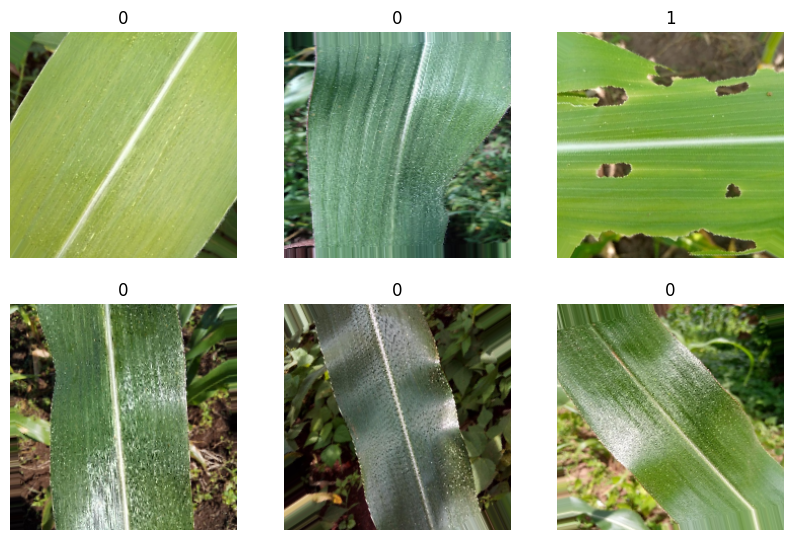

In [ ]:
plt.figure(figsize=(10, 10))
#for _ in range(len(traindata.filenames)):
for _ in range(6):
     ax = plt.subplot(3, 3, _ + 1)
     image, label = traindata.next()
     # display the image from the iterator
     label_name=new_dict[label[0]] # note you are only showing the first image of the batch
     plt.title(label_name)
     plt.imshow(image[0])
     plt.axis("off")

In [ ]:
len(traindata)

41

In [ ]:
# 'Train_df' is split into "training" and "validation sets"
#let's check the number of batches (of 32 images each)
training_ratio = 0.8
print("traindata samples: ",traindata.samples,"\n")
print("traindata batches: ", np.floor(len(Train_df) * training_ratio / traindata.batch_size)+1)
#traindata.samples

traindata samples:  1296 

traindata batches:  41.0


In [ ]:
# the validation set also:
validation_ratio = 0.2
#len(Train_df) / traindata.batch_size*validation_ratio
print("validationdata samples: ",validationdata.samples,"\n")
print("validationdata batches: ", np.floor(len(Train_df) * validation_ratio / validationdata.batch_size)+1)

validationdata samples:  323 

validationdata batches:  11.0


### BUILD MODEL BY TRANSFER LEARNING

Let’s build our model:

using a pre-trained model is what we call Transfer Learning. Transfer Learning is a method in machine learning where a model developed for a task is reused as the starting point for a model on another similar task. Transfer learning is computationally efficient and helps achieve better results using a small amount of data. For this project, we are using a pre-trained model to classify the plant image which is infected or uninfected.

We have several pre-trained models for image classification. Examples are **VGG16, VGG19, InceptionV3, ResNet50, ResNetV2, etc**. These pre-trained models have been trained on millions of images making it easier to perform better on our data.

Let’s import the pre-trained model we are using.

In [ ]:
'''Model was already called through tensorflow.keras'''
#from keras.applications.vgg19 import VGG19

We would be using VGG19 as our pretrained model. VGG19 is a variant of the VGG model which consists of 19 layers (16 convolution layers, 3 fully connected layers, 5 MaxPool layers, and 1 SoftMax layer).

Now, we are done importing the pre-trained model. We would not be loading the output layer for the model, because the **VGG19** model was initially trained with the ImageNet database that contains a million images **of 1000 classes**. Since we are working on a binary image classification we, therefore, **freeze** the initial **output layers that have 1000 classes** and **add our output layer**. We freeze the output layer **by putting False to the include_top argument**. VGG19 takes the input shape of the images 224x224 size.

In [12]:
model = VGG19(include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In the below code we set our trainable argument to false because we don’t want the VGG19 model’s weight to interfere with our current data so we freeze the weight of the pre-trained model.

In [13]:
for layer in model.layers:
    layer.trainable=False
pretrained_part = Flatten()(model.layers[-1].output)

Let's add our output layer:

In [14]:
class_ = Dense(256, activation='relu')(pretrained_part)
output = Dense(1, activation='sigmoid')(class_) #was Dense(units=2,...) with class_mode='categorical' / was 1 with 'binary'
model = Model(inputs = model.inputs, outputs = output)

Let’s compile the model using Adam as the optimizer, loss as binary_crossentropy, because it’s a binary image classification and metrics as Accuracy score

In [15]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=[('Accuracy')])

In [16]:
# CHECKING MODEL SUMMARY
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The above image is the output when you run the model.summary() code, it brings out the layers of the model. We can also see that there are 26,447,682 total parameters for the model, of which 6,423,298 are trainable parameters. The remaining 20,024,384 are non-trainable parameters, which are the weights we froze.

Let’s now train the model!!!

To train our model we pass in the train data, validation data, epochs, and steps_per_epochs this is the number of unique samples of your dataset divided by the batch size and the verbose. The verbose will show the output of the model while training.

In [33]:
history = model.fit(traindata,
           validation_data=validationdata,
           epochs=10,
           steps_per_epoch=3,
           verbose=2)

Epoch 1/10
3/3 - 339s - loss: 0.5720 - Accuracy: 0.7188 - val_loss: 0.6682 - val_Accuracy: 0.6625 - 339s/epoch - 113s/step
Epoch 2/10
3/3 - 336s - loss: 0.7397 - Accuracy: 0.6375 - val_loss: 0.5040 - val_Accuracy: 0.7461 - 336s/epoch - 112s/step
Epoch 3/10
3/3 - 343s - loss: 0.5372 - Accuracy: 0.7292 - val_loss: 0.4787 - val_Accuracy: 0.7957 - 343s/epoch - 114s/step
Epoch 4/10
3/3 - 342s - loss: 0.5901 - Accuracy: 0.7500 - val_loss: 0.6119 - val_Accuracy: 0.7337 - 342s/epoch - 114s/step
Epoch 5/10
3/3 - 329s - loss: 0.4688 - Accuracy: 0.7917 - val_loss: 0.3063 - val_Accuracy: 0.8545 - 329s/epoch - 110s/step
Epoch 6/10
3/3 - 332s - loss: 0.2226 - Accuracy: 0.9271 - val_loss: 0.4818 - val_Accuracy: 0.7802 - 332s/epoch - 111s/step
Epoch 7/10
3/3 - 342s - loss: 0.4741 - Accuracy: 0.8125 - val_loss: 0.3634 - val_Accuracy: 0.8204 - 342s/epoch - 114s/step
Epoch 8/10
3/3 - 339s - loss: 0.3300 - Accuracy: 0.8854 - val_loss: 0.2785 - val_Accuracy: 0.8854 - 339s/epoch - 113s/step
Epoch 9/10
3/3 -

The accuracy of our model is quite high.

###Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the VGG19 base model as a fixed feature extractor.

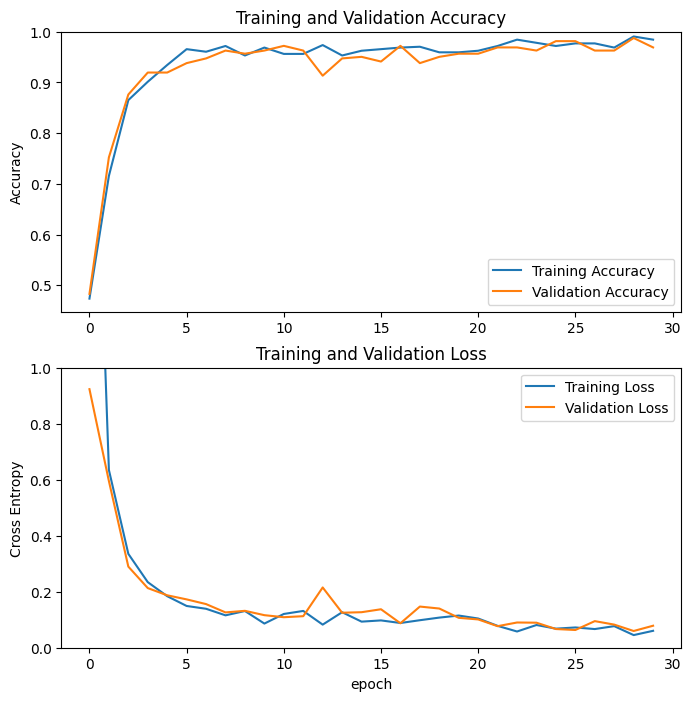

In [ ]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Let’s now create a submission CSV file by using the model to classify the images in the test data set.

In [19]:
predictions=model.predict(testdata)
predictions

34/34 [==============================] - 280s 8s/step


array([[0.06904625],
       [0.03445932],
       [0.98286116],
       ...,
       [0.20383778],
       [0.63100034],
       [0.8896797 ]], dtype=float32)

When we print out the predictions, we get two values which are the probability of each label being the actual value. This can be quite confusing, to avoid this we use the argmax() function from the Numpy library. The argmax function prints the index of the maximum value. If the first value is maximum it prints out 0, if the second value is maximum it prints out 1.

In [20]:
'''' TO BE UPDATED as argmax() needs more than 1 output argument'''
#pred_labels=[ np.argmax(i) for i in predictions] # OK for categorical only
pred_labels = np.round(predictions.flatten(), 0) # OK for binary or sparse
#print(pred_labels)
print(pred_labels[:6])

[0. 0. 1. 0. 0. 0.]


#### **Run prediction on a sample image**

In [ ]:
import numpy as np

for image_batch, label_batch in testdata:
    first_image = image_batch[0]
    first_label = int(label_batch[0])

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    break

#### **Write a function for inference**

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in testdata:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

### SAVE MODEL & WRITE LABELS IN CSV

Now we have converted the prediction probability to target labels

The submission csv contains the test.csv file image_id , let’s read the submission CSV file and create a Label column

In [ ]:
''' WHY DOES model.evaluate give [0,0] ? '''
#other calls: Scores is just a list containing loss and accuracy value
scores = model.evaluate(testdata)
scores

34/34 [==============================] - 10s 280ms/step - loss: 0.0000e+00 - Accuracy: 0.0000e+00


[0.0, 0.0]

In [ ]:
#history
'''
history
<tensorflow.python.keras.callbacks.History at 0x7f3d98437e50>
You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

history.params
{'verbose': 1, 'epochs': 50, 'steps': 54}

history.history.keys()
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

type(history.history['loss'])
list
len(history.history['loss'])
50
history.history['loss'][:5] # show loss for first 5 epochs
[0.8801848292350769,
 0.6033139228820801,
 0.3646925389766693,
 0.2776017189025879,
 0.24480397999286652]
 '''


#### Saving the Model
We append the model to the list of models as a new version

In [ ]:
!dir

drive  sample_data


In [26]:
#METHOD 1
#models_path = "/content/drive/MyDrive/crop-disease/saved_models1"
#model_version=max([int(i) for i in os.listdir(models_path) + [0]])+1
#model.save(f"{models_path}/{model_version}")
# h5 format
model.save("/content/drive/MyDrive/crop-disease/saved_models1/myVGG19_model1.h5")
#INFO:tensorflow:Assets written to: ../models/3/assets

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
#METHOD 2 (Keras 3)
models_path = "/content/drive/MyDrive/crop-disease/saved_models2"
model_version=max([int(i) for i in os.listdir(models_path) + [0]])+1
tf.saved_model.save(model, f"{models_path}/{model_version}")
#INFO:tensorflow:Assets written to: ../models/3/assets

In [34]:
''' TO USE NEXT IF PREVIOUS SAVE DOES NOT WORK'''
# or Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
#tf.saved_model.save(model, "/content/drive/MyDrive/crop-disease/saved_models2/myVGG19_model2.keras")

#OR Save model in h5 format so that there is just one file and we can upload that to GCP conveniently
tf.saved_model.save(model, "/content/drive/MyDrive/crop-disease/saved_models2/myVGG19_model2.h5")

In [36]:
# Method 3: USING API WAY
tf.keras.saving.save_model(model, "/content/drive/MyDrive/crop-disease/saved_models3/myVGG19_model3.keras")
tf.keras.saving.save_model(model, "/content/drive/MyDrive/crop-disease/saved_models3/1")

In [ ]:

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/crop-disease/myVGG19_model.keras")
'''
# Let's check:
np.testing.assert_allclose(
    model.predict(test_input), reconstructed_model.predict(test_input)
)
'''

"\n# Let's check:\nnp.testing.assert_allclose(\n    model.predict(test_input), reconstructed_model.predict(test_input)\n)\n"

In [ ]:
submit=pd.read_csv('/content/drive/MyDrive/crop-disease/SampleSubmission.csv')
submission = pd.DataFrame({ 'Image_id':submit.Image_id.values, 'Label': pred_labels})
submission.to_csv("my_submission.csv", index=False) # Creates csv in the 'content' folder

When this code is done executing , a new csv file called my_submission csv will be created on your drive. This is what you will download and upload as your submission .

Finally, we have a model that can predict if a plant is infected or uninfected. I recommend you try out other pre-trained models and compare their accuracy scores.

For more clarifications on this project check out my https://github.com/Oreoluwa1234/Zindi-Makerere-crop-disease-Prediction.